In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, accuracy_score
from sklearn.preprocessing import LabelEncoder

# this will be used to access the bigquery client
from google.cloud import bigquery
# this will be used to access the service account modules - passwords and access tokens
from google.oauth2 import service_account
# this will be used for returning data, increases the speed
from google.cloud import bigquery_storage
# for os library
import os

# required for certain returns
import pandas_gbq
# exception for a short script
from google.api_core.exceptions import NotFound

In [2]:
# pip install xgboost

In [3]:
# pip install scikit-learn

In [4]:
# Path to service account if stored locally
SERVICE_ACCOUNT_JSON = r"..\portfolio2026-485323-70c4d609b156.json"

# Credentials to access Big Query via the service account
credentials = service_account.Credentials.from_service_account_file(SERVICE_ACCOUNT_JSON)

# BigQuery client
client = bigquery.Client(credentials=credentials, project=credentials.project_id)

# BigQuery Storage client
bq_storage_client = bigquery_storage.BigQueryReadClient(credentials=credentials)

# Query the complete data set
query = """
SELECT *
FROM `portfolio2026-485323.portfolio1.sample_data`
"""

# Execute the query and use the bqstorage for faster data retrieval
df = client.query(query).to_dataframe(bqstorage_client=bq_storage_client)

# Dsiplay the data
display(df.head())

,rk,player,pos,age,tm,g,gs,mp,fg,fga,...,trb,ast,stl,blk,tov,pf,pts,year,trp_dbl,awards
0,26,LaMelo Ball,PG,19,CHO,51,31,1469,293,672,...,302,313,81,18,145,136,803,2021,NaN,NaN
1,92,Vernon Carey Jr.,C,19,CHO,19,4,115,18,36,...,27,2,1,5,5,13,46,2021,NaN,NaN
2,141,Anthony Edwards,SG,19,MIN,72,55,2314,505,1211,...,336,211,82,36,160,129,1392,2021,NaN,NaN
3,199,R.J. Hampton,SG,19,TOT,51,1,888,136,313,...,179,87,21,10,53,61,354,2021,NaN,NaN
4,199,R.J. Hampton,SG,19,DEN,25,0,233,25,60,...,50,14,5,2,11,22,64,2021,NaN,NaN


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2931 entries, 0 to 2930
Data columns (total 33 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   rk       2931 non-null   Int64  
 1   player   2931 non-null   object 
 2   pos      2931 non-null   object 
 3   age      2931 non-null   Int64  
 4   tm       2931 non-null   object 
 5   g        2931 non-null   Int64  
 6   gs       2931 non-null   Int64  
 7   mp       2931 non-null   Int64  
 8   fg       2931 non-null   Int64  
 9   fga      2931 non-null   Int64  
 10  fg_      2907 non-null   float64
 11  3p       2931 non-null   Int64  
 12  3pa      2931 non-null   Int64  
 13  3p_      2755 non-null   float64
 14  2p       2931 non-null   Int64  
 15  2pa      2931 non-null   Int64  
 16  2p_      2879 non-null   float64
 17  efg_     2907 non-null   float64
 18  ft       2931 non-null   Int64  
 19  fta      2931 non-null   Int64  
 20  ft_      2726 non-null   float64
 21  orb      2931 

## Machine Learning

In [6]:
#remove players with less than 50 games
df50 = df[df['g'] >=50].copy()

In [7]:
df50.shape

(1157, 33)

In [8]:
df50.head()

,rk,player,pos,age,tm,g,gs,mp,fg,fga,...,trb,ast,stl,blk,tov,pf,pts,year,trp_dbl,awards
0,26,LaMelo Ball,PG,19,CHO,51,31,1469,293,672,...,302,313,81,18,145,136,803,2021,NaN,NaN
2,141,Anthony Edwards,SG,19,MIN,72,55,2314,505,1211,...,336,211,82,36,160,129,1392,2021,NaN,NaN
3,199,R.J. Hampton,SG,19,TOT,51,1,888,136,313,...,179,87,21,10,53,61,354,2021,NaN,NaN
7,296,Kira Lewis Jr.,PG,19,NOP,54,0,904,130,337,...,71,124,38,10,34,88,343,2021,NaN,NaN
8,309,Théo Maledon,PG,19,OKC,65,49,1778,226,614,...,211,227,56,11,141,126,658,2021,NaN,NaN


In [9]:
df50.drop(columns='awards', inplace=True)
df50['trp_dbl'] = df50['trp_dbl'].fillna(0)

In [10]:
#no null values
df50.isnull().sum().sum()

np.int64(20)

In [11]:
df50.shape

(1157, 32)

## These 20 players do not have a 3 point shot percentage

They also did not take a 3 point attempt so it is not accurate to list them as having 0% for the 3 point shot

In [12]:
df50[df50['3p_'].isna()][['player', 'fg','fga','3pa']]

,player,fg,fga,3pa
294,Jalen Duren,378,546,0
350,Daniel Gafford,154,225,0
668,Mitchell Robinson,261,343,0
866,Tony Bradley,72,123,0
909,Nick Richards,60,90,0
923,Ivica Zubac,310,495,0
942,Daniel Gafford,289,395,0
968,Mitchell Robinson,188,280,0
1113,Jakob Poeltl,265,430,0
1305,Clint Capela,413,695,0


# An NBA season is 82 games
A player cannot play more than 82 games unless they were traded

In [13]:
df50[df50['g'] >82]

,rk,player,pos,age,tm,g,gs,mp,fg,fga,...,drb,trb,ast,stl,blk,tov,pf,pts,year,trp_dbl
1410,58,Mikal Bridges,SF-SG,26,TOT,83,83,2963,593,1267,...,285,364,273,91,61,127,159,1671,2023,0.0


# Games played and Minutes played should have a positive correlation.

As a player playsm more games they will often have more minutes available to play. Now each player plays a different amount of minutes as a team divides minutes among their players based on performance and other considerations, like rest or matchups.

In [14]:
correlation_df_ex = df50[['g','mp']].corr()
correlation_mp_g = round(correlation_df_ex.iloc[1,0],2)
correlation_mp_g

np.float64(0.62)

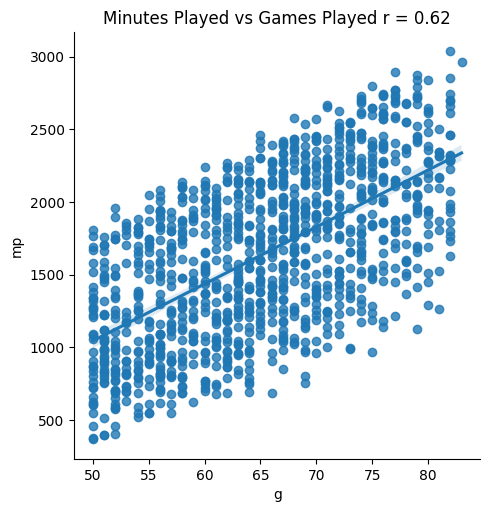

In [15]:
sns.lmplot(data=df50, x='g', y='mp')
plt.title(f'Minutes Played vs Games Played r = {correlation_mp_g}');

In [16]:
#select dtypes = numeric
df50_numeric = df50.select_dtypes('number').drop(columns=['age', 'year'])

In [17]:
df50_numeric.corr().head()

,rk,g,gs,mp,fg,fga,fg_,3p,3pa,3p_,...,orb,drb,trb,ast,stl,blk,tov,pf,pts,trp_dbl
rk,1.000000,-0.101193,-0.185436,-0.219511,-0.216733,-0.214525,0.001980,-0.169601,-0.170257,-0.014878,...,-0.048980,-0.141015,-0.121045,-0.124019,-0.164285,-0.069821,-0.148209,-0.046781,-0.221644,-0.124771
g,-0.101193,1.000000,0.364124,0.619799,0.387467,0.385393,0.079721,0.332462,0.336441,0.067898,...,0.263101,0.375608,0.365617,0.260142,0.406681,0.228280,0.295691,0.538339,0.372033,0.041058
gs,-0.185436,0.364124,1.000000,0.838828,0.727465,0.704397,0.150410,0.407201,0.419334,0.027109,...,0.341405,0.611402,0.566846,0.554432,0.556607,0.345983,0.639639,0.589091,0.713193,0.103493
mp,-0.219511,0.619799,0.838828,1.000000,0.844899,0.851567,0.039058,0.607157,0.623333,0.160443,...,0.260159,0.635096,0.558040,0.654792,0.675536,0.272977,0.725036,0.645006,0.840649,0.122297
fg,-0.216733,0.387467,0.727465,0.844899,1.000000,0.970416,0.149001,0.554140,0.572061,0.135587,...,0.250064,0.655068,0.569636,0.684202,0.544139,0.250545,0.831983,0.505185,0.988344,0.183410


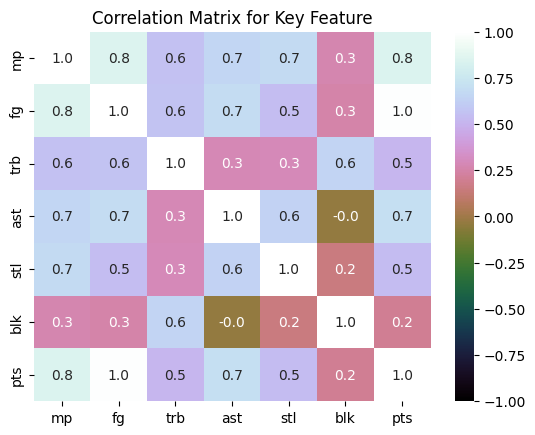

In [18]:
sns.heatmap(df50_numeric[['mp', 'fg', 'trb', 'ast', 'stl', 'blk', 'pts']].corr(),annot=True, fmt=".1f", cmap = 'cubehelix', vmin=-1, vmax=1)
plt.title('Correlation Matrix for Key Feature');

# Remove NA values for PCA

NA values need to be removed for to perform Principal Components Analysis. PCA is a vital tool for dimension reduction, reducing the effect of colinearity. We see above that some of our variables are correlated around .8 or more. Therefore, these variables provide a similar signal and reduce the benefit of having more variables.

PCA finds the main components that explain variance by a method of dimension reduction based in linear algebra.

In this example, I will replace the missing values with 0. The players are Centers and generally do not take 3 point shots because they are so bad at it. 0% does, in this case, actually approximate their shooting ability.

In [35]:
df50_numeric.fillna(0, inplace=True)

# Dimension reduction

In [75]:
X = df50_numeric.copy() # label X for convention

In [76]:
X.drop(columns='rk',inplace=True)

In [77]:
X.reset_index(drop=True,inplace=True)
X.head()

,g,gs,mp,fg,fga,fg_,3p,3pa,3p_,2p,...,orb,drb,trb,ast,stl,blk,tov,pf,pts,trp_dbl
0,51,31,1469,293,672,0.436,92,261,0.352,201,...,63,239,302,313,81,18,145,136,803,0.0
1,72,55,2314,505,1211,0.417,171,520,0.329,334,...,59,277,336,211,82,36,160,129,1392,0.0
2,51,1,888,136,313,0.435,27,87,0.310,109,...,29,150,179,87,21,10,53,61,354,0.0
3,54,0,904,130,337,0.386,40,120,0.333,90,...,12,59,71,124,38,10,34,88,343,0.0
4,65,49,1778,226,614,0.368,105,313,0.335,121,...,25,186,211,227,56,11,141,126,658,0.0


## First scale the data using the standard scaler

In [78]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

## Run PCA - find the principal components

In [79]:
from sklearn.decomposition import PCA

pca = PCA()
X_pca = pca.fit_transform(X_scaled)

## Different methods of selecting the number of components

In [80]:
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

## In this case I will select the number of components that explain 80% of the variance

In [81]:
pca = PCA(n_components=0.8)  # keep 90% of variance
X_pca = pca.fit_transform(X_scaled)

pca.n_components_

np.int64(5)

In [82]:
pca.explained_variance_ratio_

array([0.44407131, 0.2114355 , 0.06727047, 0.0538053 , 0.03897557])

In [83]:
np.cumsum(pca.explained_variance_ratio_)

array([0.44407131, 0.65550681, 0.72277729, 0.77658258, 0.81555816])

Large absolute values → variable strongly influences that PC

Signs matter (direction of relationship)

In [84]:
loadings = pd.DataFrame(
    pca.components_.T,
    columns=[f"PC{i+1}" for i in range(pca.n_components_)],
    index=X.columns
)

loadings

,PC1,PC2,PC3,PC4,PC5
g,0.139408,0.014329,0.443241,-0.222035,0.038523
gs,0.236712,0.011588,0.115145,-0.105025,-0.056298
mp,0.265272,-0.056996,0.217153,-0.104875,-0.011101
fg,0.283204,-0.043456,-0.039428,0.129216,-0.041088
fga,0.272553,-0.130047,-0.027999,0.066152,-0.063117
fg_,0.057212,0.368955,0.030932,0.306571,0.013029
3p,0.142948,-0.289639,0.309846,0.145975,-0.004598
3pa,0.149899,-0.297837,0.267856,0.092244,-0.024787
3p_,0.020177,-0.263007,0.211337,0.184863,0.132481
2p,0.266173,0.088123,-0.195911,0.082543,-0.046393


In [85]:
pca_df = pd.DataFrame(
    X_pca,
    columns=[f"PC{i+1}" for i in range(pca.n_components_)],
    index=X.index
)

pca_df.head()

,PC1,PC2,PC3,PC4,PC5
0,0.444924,-1.163129,-1.373176,-0.713176,0.247768
1,4.068504,-2.198748,-0.165173,-0.665164,-0.574992
2,-4.025506,-0.424416,-2.171695,-0.429770,-0.101841
3,-4.145147,-2.220446,-1.756474,-0.999551,-0.109918
4,-0.428377,-2.638243,-0.677871,-2.055364,-0.076104


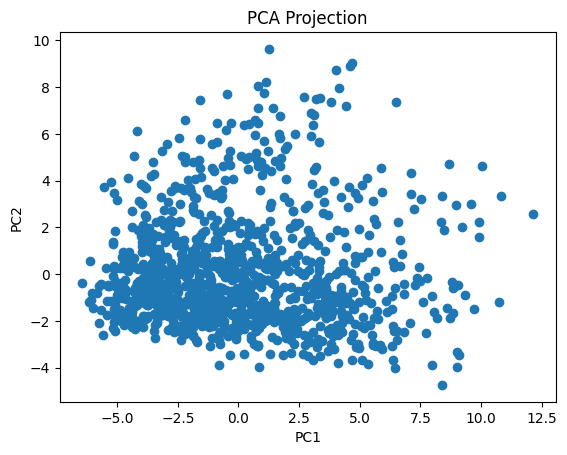

In [86]:
import matplotlib.pyplot as plt

plt.scatter(pca_df["PC1"], pca_df["PC2"])
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("PCA Projection")
plt.show()


In [105]:
df50['pos'].unique()

array(['PG', 'SG', 'C', 'PF', 'SF'], dtype=object)

In [102]:
df50.replace({'SG-PG':'PG', 'SG-SF':'SG','SF-PF':'SF','SF-SG':'SF','PF-C':'PF','C-PF':'PF','PF-SF':'PF','SG-PG-SF':'SG','PG-SG':'PG'},inplace=True)

In [103]:
# Encode the categorical target
le = LabelEncoder()
df50.loc[:,'Pos_encoded'] = le.fit_transform(df50.loc[:,'pos']) # type:ignore

y=df50['Pos_encoded'].copy()

In [104]:
pd.DataFrame(y)['Pos_encoded'].unique()

array([2, 4, 0, 1, 3])

In [106]:
# Step 4: Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

# 🌲 Step 5: Initialize and train XGBoost model
model = xgb.XGBClassifier(
    n_estimators=500,
    early_stopping_rounds=10,
    eval_metric= 'mlogloss',              # multiclass log loss
    learning_rate=0.1, 
    max_depth=3,
    random_state=42                          
)  # for classification

# model = xgb.XGBRegressor()  # use this for regression tasks
model.fit(
    X_train,
    y_train,
    eval_set=[(X_val, y_val)],
    verbose=True
)


# 🎯 Step 6: Make predictions and evaluate
y_pred = model.predict(X_test)

# 🧠 Step 7: Evaluate (choose the right metric)
print("Accuracy:", accuracy_score(y_test, y_pred))
# For regression: print("MSE:", mean_squared_error(y_test, y_pred))


[0]	validation_0-mlogloss:1.54718
[1]	validation_0-mlogloss:1.49828
[2]	validation_0-mlogloss:1.45893
[3]	validation_0-mlogloss:1.42233
[4]	validation_0-mlogloss:1.39049
[5]	validation_0-mlogloss:1.36495
[6]	validation_0-mlogloss:1.33526
[7]	validation_0-mlogloss:1.30593
[8]	validation_0-mlogloss:1.28200
[9]	validation_0-mlogloss:1.26167
[10]	validation_0-mlogloss:1.24160
[11]	validation_0-mlogloss:1.22511
[12]	validation_0-mlogloss:1.20813
[13]	validation_0-mlogloss:1.19056
[14]	validation_0-mlogloss:1.17868
[15]	validation_0-mlogloss:1.16963
[16]	validation_0-mlogloss:1.15701
[17]	validation_0-mlogloss:1.14693
[18]	validation_0-mlogloss:1.14077
[19]	validation_0-mlogloss:1.13435
[20]	validation_0-mlogloss:1.12705
[21]	validation_0-mlogloss:1.11796
[22]	validation_0-mlogloss:1.11564
[23]	validation_0-mlogloss:1.11224
[24]	validation_0-mlogloss:1.10593
[25]	validation_0-mlogloss:1.10097
[26]	validation_0-mlogloss:1.09841
[27]	validation_0-mlogloss:1.09585
[28]	validation_0-mlogloss:1.0

In [107]:
probs = model.predict_proba(X_test)

# Get predicted class
predicted_class = np.argmax(probs, axis=1)

# Map back to labels if needed
final_predictions = le.inverse_transform(predicted_class)

In [108]:
np.round(probs, decimals=2)[:10]

array([[0.03, 0.55, 0.01, 0.37, 0.04],
       [0.03, 0.44, 0.09, 0.13, 0.3 ],
       [0.07, 0.81, 0.  , 0.11, 0.02],
       [0.3 , 0.52, 0.01, 0.15, 0.02],
       [0.7 , 0.27, 0.  , 0.03, 0.01],
       [0.02, 0.16, 0.07, 0.47, 0.28],
       [0.01, 0.02, 0.15, 0.12, 0.7 ],
       [0.  , 0.01, 0.91, 0.01, 0.06],
       [0.01, 0.38, 0.02, 0.28, 0.31],
       [0.25, 0.58, 0.01, 0.12, 0.03]], dtype=float32)

In [109]:
# Your predictions
y_pred = model.predict(X_test)
y_proba = model.predict_proba(X_test)[:, 1]  # Probabilities for ROC-AUC

from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, classification_report

# Use 'macro', 'weighted', or 'micro' depending on your goal
print("Precision (macro):", precision_score(y_test, y_pred, average='macro'))
print("Recall (macro):", recall_score(y_test, y_pred, average='macro'))
print("F1 Score (macro):", f1_score(y_test, y_pred, average='macro'))

# Optional: 'weighted' is often good if classes are imbalanced
# print("Precision (weighted):", precision_score(y_test, y_pred, average='weighted'))

# Classification report handles all classes
print("\nClassification Report:\n", classification_report(y_test, y_pred, target_names=le.classes_))



Precision (macro): 0.6015511615734195
Recall (macro): 0.5952249486385622
F1 Score (macro): 0.5764360937986892

Classification Report:
               precision    recall  f1-score   support

           C       0.81      0.81      0.81        53
          PF       0.31      0.53      0.39        34
          PG       0.69      0.78      0.73        37
          SF       0.58      0.22      0.32        49
          SG       0.62      0.63      0.62        59

    accuracy                           0.59       232
   macro avg       0.60      0.60      0.58       232
weighted avg       0.62      0.59      0.59       232



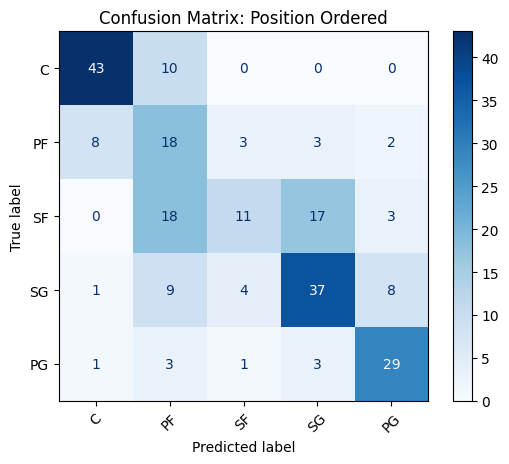

In [111]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Custom class order
custom_order = ['C', 'PF', 'SF', 'SG', 'PG']

# Convert custom label order to integer label indices
custom_indices = le.transform(custom_order)

# Compute confusion matrix in desired label order
cm = confusion_matrix(y_test, y_pred, labels=custom_indices)

# Display with custom labels
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=custom_order)
disp.plot(cmap='Blues', xticks_rotation=45)
plt.title("Confusion Matrix: Position Ordered")
plt.grid(False)
plt.show()


In [114]:
# pip install shap

In [115]:
import shap

c:\Users\nick\AppData\Local\Python\pythoncore-3.14-64\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [116]:
# Class index 0 corresponds to this label:
print(le.inverse_transform([0,1,2,3,4]))  # e.g., ['starter']

['C' 'PF' 'PG' 'SF' 'SG']


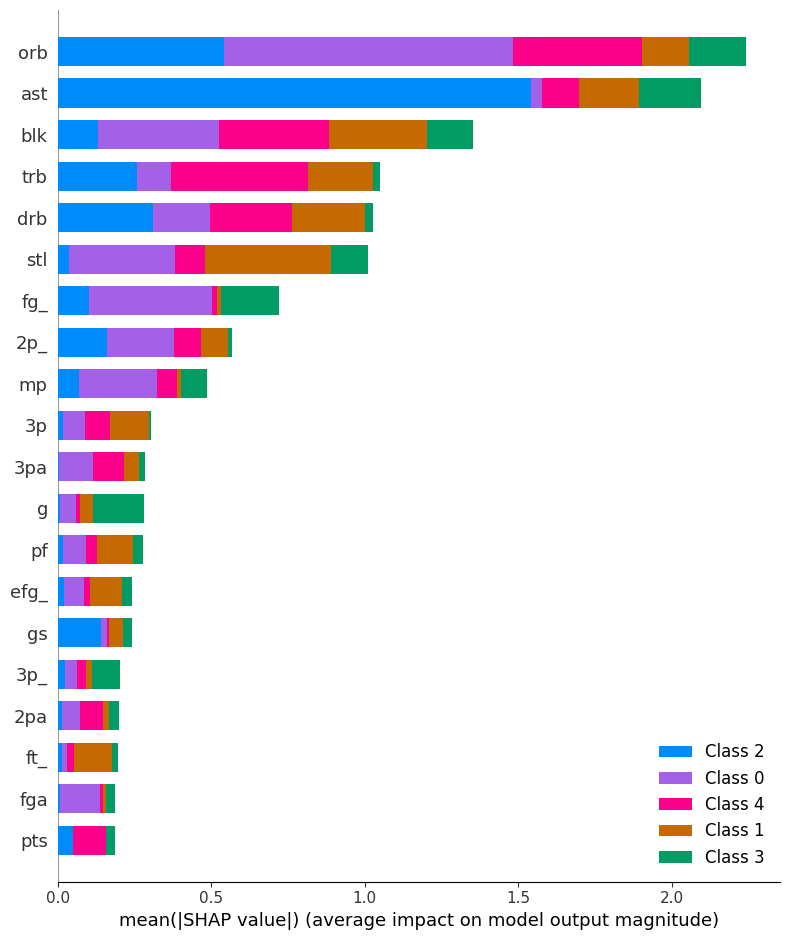

In [117]:
# Optional: silence warnings
import warnings
warnings.filterwarnings("ignore")

# Step 1: Create SHAP explainer
explainer = shap.Explainer(model)

# Step 2: Compute SHAP values
shap_values = explainer(X_test)

# Step 3: Summary plot (global feature importance)
shap.summary_plot(shap_values, X_test)

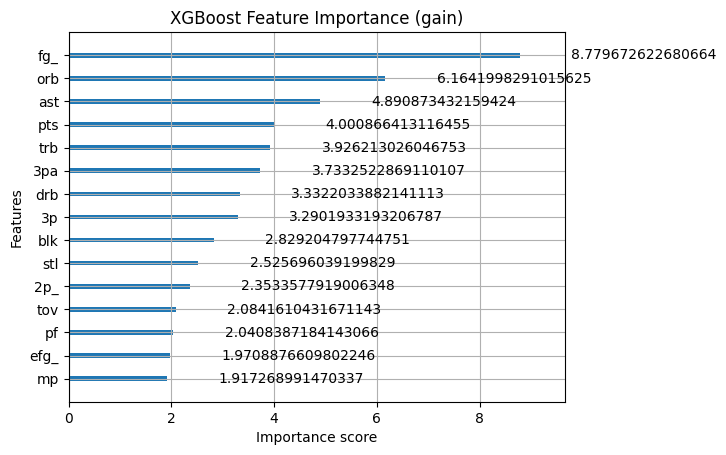

In [118]:
from xgboost import plot_importance

# Plot feature importance (based on model gain)
plot_importance(model, importance_type='gain', max_num_features=15)
plt.title('XGBoost Feature Importance (gain)')
plt.show()

In [119]:
importance = model.get_booster().get_score(importance_type='gain')
importance_df = pd.DataFrame({
    'Feature': list(importance.keys()),
    'Importance': list(importance.values())
}).sort_values(by='Importance', ascending=False)

display(importance_df.head(10))


,Feature,Importance
5,fg_,8.779673
16,orb,6.164200
19,ast,4.890873
24,pts,4.000866
18,trb,3.926213
7,3pa,3.733252
17,drb,3.332203
6,3p,3.290193
21,blk,2.829205
20,stl,2.525696


In [122]:
from sklearn.dummy import DummyClassifier
from sklearn.metrics import classification_report, accuracy_score

# Step 1: Train dummy model
dummy = DummyClassifier(strategy='uniform')  # or 'stratified', 'uniform','most_frequent'
dummy.fit(X_train, y_train)

# Step 2: Predict and evaluate
y_dummy_pred = dummy.predict(X_test)

print("Dummy Model Accuracy:", accuracy_score(y_test, y_dummy_pred))
print("\nDummy Classification Report:\n", classification_report(y_test, y_dummy_pred, target_names=le.classes_))


Dummy Model Accuracy: 0.19827586206896552

Dummy Classification Report:
               precision    recall  f1-score   support

           C       0.21      0.17      0.19        53
          PF       0.16      0.21      0.18        34
          PG       0.21      0.24      0.23        37
          SF       0.15      0.16      0.15        49
          SG       0.27      0.22      0.24        59

    accuracy                           0.20       232
   macro avg       0.20      0.20      0.20       232
weighted avg       0.21      0.20      0.20       232



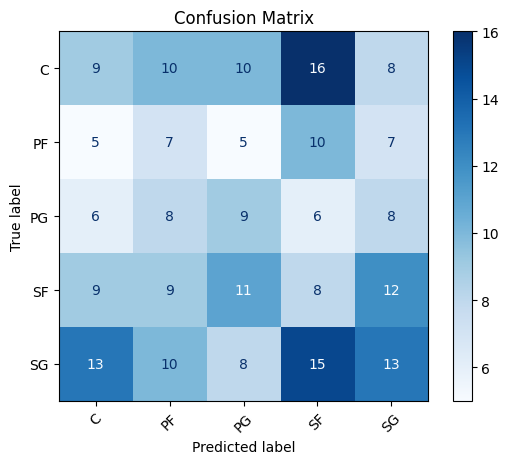

In [123]:
cm_dummy = confusion_matrix(y_test, y_dummy_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm_dummy, display_labels=le.classes_)
disp.plot(cmap='Blues', xticks_rotation=45)
plt.title("Confusion Matrix")
plt.grid(False)
plt.show()